In [2]:
import numpy as np

class DecisionStump:
    def __init__(self , feature_idx : int = None , threshold :any = None , polarity : int = 1 , amount_to_say : int = None) -> None:
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.polarity = polarity
        self.amount_to_say = amount_to_say

    def predict(self , X : np.ndarray):
        X_c = X[: , self.feature_idx]
        n_sample = X.shape[0]
        y_pred = np.ones(n_sample)

        if self.polarity == 1:
            y_pred[X_c < self.threshold] = -1
        else :
            y_pred[X_c > self.threshold] = -1
        
        return y_pred

            
class Adaboost:
    
    def __init__(self , n_classifiers : int = 5,verbose : bool = False ) -> None:
        self.n_classifiers = n_classifiers
        self.verbose = verbose
        self.classifiers = []

    def fit(self , X : np.ndarray , y : np.ndarray ):
        n_samples , n_features = X.shape
        self.X = X
        # initialise the error weights of each sample to 1/n_samples
        w = np.full(n_samples , (1/n_samples))

        for _ in range(self.n_classifiers):

            min_error = float('inf')
            stump = DecisionStump()

            for feature_idx in range(n_features):
                X_c = self.X[: , feature_idx]
                unique_features = np.unique(X_c)
            
                for threshold in unique_features:
                    p = 1

                    predictions = np.ones(n_samples)
                    predictions[X_c < threshold] = -1
                    total_error   = sum(w[predictions != y])

                    # # if total error is greater than 0.5 reverse the polarity the left classified becomes 1
                    if total_error > 0.5:
                        p = -1   
                        total_error = 1 - total_error

                    if total_error < min_error:
                        min_error = total_error
                        stump.feature_idx = feature_idx
                        stump.threshold = threshold
                        stump.polarity = p

            # change the error for the next stump to get more accurate on the sample which is currently wrongly classified
            
            EPS = 1e-15           # to avoid underflow
            stump.amount_to_say = 0.5 * np.log((1-total_error + EPS)/(total_error+EPS))
            y_pred = stump.predict(X)       

            w = w*np.exp(-stump.amount_to_say*y*y_pred)
            # to normalise between 0 to 1 of sample error weights
            w = w/np.sum(w)

            self.classifiers.append(stump)

    def predict(self , X):
        stumps_pred = [stump.amount_to_say * stump.predict(X) for stump in self.classifiers]
        y_pred = np.sum(stumps_pred , axis=0)
        y_pred = np.sign(y_pred)
        return y_pred

def accuracy(y_true : np.ndarray , y_pred : np.ndarray):
    acc = np.sum(y_true == y_pred)/y_pred.shape[0]
    return acc

In [29]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd

data = datasets.load_breast_cancer()
X, y = data.data, data.target

df = pd.DataFrame(data=X,columns= data['feature_names'])


print(df.describe())

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

In [28]:
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5
)
clf = Adaboost(n_classifiers=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9473684210526315


In [10]:
from sklearn.metrics import classification_report , confusion_matrix

print("[+] CLASSIFICATION REPORT FOR ADABOOST\n")
print(classification_report(y_test,y_pred))

print("\n[+] CONFUSION MATRIX")
print(confusion_matrix(y_test , y_pred))

[+] CLASSIFICATION REPORT FOR ADABOOST

              precision    recall  f1-score   support

          -1       0.98      0.90      0.93        48
           1       0.93      0.98      0.96        66

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.95       114
weighted avg       0.95      0.95      0.95       114


[+] CONFUSION MATRIX
[[43  5]
 [ 1 65]]


<AxesSubplot:>

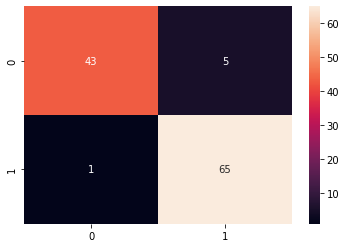

In [30]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test , y_pred) , annot=True)